# 생물정보학 및 실습 1 - Term Project용 환경 셋업

```
생물정보학 및 실습 1
서울대학교 생물정보학전공/생명과학부 2024년 1학기

이 노트북은 Creative Commons BY-SA 조건으로 재사용 가능합니다.
장혜식 <hyeshik@snu.ac.kr>, 서울대학교 생명과학부
```

```
여진기 <jingiyeo@snu.ac.kr>
```

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!git clone https://github.com/hyeshik/colab-biolab.git
!cd colab-biolab && bash tools/setup.sh
exec(open('colab-biolab/tools/activate_conda.py').read())

Cloning into 'colab-biolab'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 76 (delta 26), reused 59 (delta 15), pack-reused 0
Receiving objects: 100% (76/76), 318.16 KiB | 8.84 MiB/s, done.
Resolving deltas: 100% (26/26), done.
./
./root/
./root/.bashrc.biolab
./root/.profile
./root/.condarc
./root/.bin.priority/
./root/.bin.priority/pip
./root/.bin.priority/pip2
./root/.bin.priority/pip3
./root/.vimrc
./root/.tmux.conf
--2024-06-13 11:13:56--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.32.241, 104.16.191.158, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.32.241|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143808873 (137M) [application/octet-stream]
Saving to: ‘miniconda3.sh’

miniconda3.sh       100%[===================>] 137.15M   

In [4]:
%cd /content/drive/MyDrive/binfo1-work

/content/drive/MyDrive/binfo1-work


자! bam 파일에 담긴 aligned reads와 gtf 파일에 담긴 gene annotation으로 gene별 read count를 구합니다.

결과를 pandas로 읽어와 봅니다.

In [5]:
import pandas as pd
cnts = pd.read_csv('read-counts.txt', sep='\t', comment='#', index_col=0)

In [6]:
cnts = cnts.reset_index()

In [213]:
cnts['clip_enrichment'] = cnts['CLIP-35L33G.bam'] / cnts['RNA-control.bam']
cnts['rden_change'] = (cnts['RPF-siLin28a.bam'] / cnts['RNA-siLin28a.bam']) / (cnts['RPF-siLuc.bam'] / cnts['RNA-siLuc.bam'])

In [214]:
cnts = cnts[(cnts['RNA-control.bam'] >= 30) & (cnts['RNA-siLuc.bam'] >= 30) &(cnts['RPF-siLuc.bam'] >= 80)].copy()

In [215]:
upregulated_genes = cnts['Geneid'].tolist()
upreg_ids = list(map(lambda x: x.split('.')[0], upregulated_genes))
print("number of genes:", len(upreg_ids))

number of genes: 7988


In [13]:
!pip install gseapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.9/552.9 kB 6.1 MB/s eta 0:00:00


In [216]:
import gseapy as gp

bm = gp.biomart.Biomart()

In [217]:
def batched(iterable, n):
    items = []
    for item in iterable:
        items.append(item)
        if len(items) == n:
            yield items
            items = []
    if items:
        yield items

results = []

for batch in batched(upreg_ids, 200):
    res = bm.query(dataset='mmusculus_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name'],
                   filters={'ensembl_gene_id': batch})
    results.append(res)

results = pd.concat(results)
results.head()

,ensembl_gene_id,external_gene_name
0,ENSMUSG00000001138,Cnnm3
1,ENSMUSG00000001143,Lman2l
2,ENSMUSG00000003135,Cnot11
3,ENSMUSG00000004364,Cul3
4,ENSMUSG00000004768,Rab23


In [218]:
# assign external gene name for gene enrich r
cnts['ensembl_gene_id'] = cnts['Geneid'].apply(lambda x: x.split('.')[0])
id_gene_A = pd.merge(results, cnts[['ensembl_gene_id', 'clip_enrichment', 'rden_change']], left_on='ensembl_gene_id', right_on='ensembl_gene_id', how='left')
id_gene_A

,ensembl_gene_id,external_gene_name,clip_enrichment,rden_change
0,ENSMUSG00000001138,Cnnm3,2.253968,0.810851
1,ENSMUSG00000001143,Lman2l,2.880000,1.014940
2,ENSMUSG00000003135,Cnot11,2.110818,0.416632
3,ENSMUSG00000004364,Cul3,7.556582,0.624345
4,ENSMUSG00000004768,Rab23,1.464481,0.522033
...,...,...,...,...
7983,ENSMUSG00000081289,Gm14857,4.444988,0.312017
7984,ENSMUSG00000082121,Gm8199,1.329331,0.334561
7985,ENSMUSG00000083207,Gm14780,1.465116,0.542926
7986,ENSMUSG00000095597,Rps7-ps3,0.391304,0.840821


In [219]:
upreg_genenames = results['external_gene_name'].dropna().drop_duplicates().tolist()
len(upreg_genenames)

7988

                     Gene_set  \
0  GO_Molecular_Function_2018   
1  GO_Molecular_Function_2018   
2  GO_Molecular_Function_2018   
3  GO_Molecular_Function_2018   
4  GO_Molecular_Function_2018   

                                                Term    Overlap  \
0                           RNA binding (GO:0003723)  1102/1387   
1                      cadherin binding (GO:0045296)    232/313   
2                          mRNA binding (GO:0003729)    142/179   
3  ubiquitin-like protein ligase binding (GO:0044...    198/297   
4      ubiquitin protein ligase binding (GO:0031625)    189/284   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.102544e-213     2.256029e-210            0                     0   
1   4.118995e-35      2.209841e-32            0                     0   
2   3.471930e-27      1.241793e-24            0                     0   
3   6.817485e-21      1.828790e-18            0                     0   
4   7.088830e-20      1.521263e-1

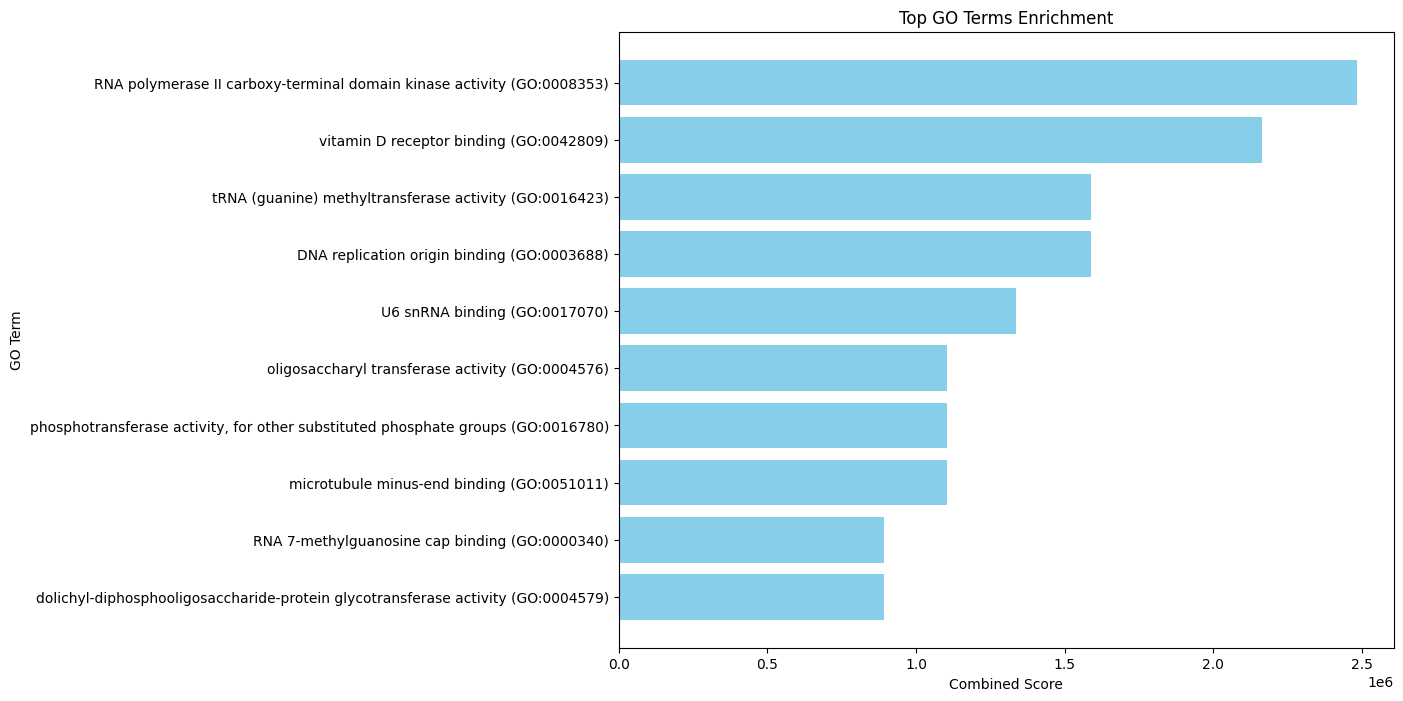

In [220]:
import matplotlib.pyplot as plt

# Enrichr 분석 수행
enr = gp.enrichr(gene_list=upreg_genenames,
                 gene_sets=['GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018'],
                 organism='Mouse',
                 outdir='test/enrichr_kegg',
                 cutoff=1)

# 결과를 데이터프레임으로 변환
enr_results = enr.res2d

# 결과 출력
print(enr_results.head())

# 상위 10개의 결과를 시각화
def plot_enrichr_results(results, top_term=10):
    s_res = results.nlargest(10, 'Combined Score')
    plt.figure(figsize=(10, 8))
    plt.barh(s_res['Term'], s_res['Combined Score'], color='skyblue')
    plt.xlabel('Combined Score')
    plt.ylabel('GO Term')
    plt.title('Top GO Terms Enrichment')
    plt.gca().invert_yaxis()
    plt.show()

# 시각화
plot_enrichr_results(enr_results)


In [221]:
s = set()
for ele in list(map(lambda x: x.split(';'), list(enr_results['Genes']))):
  for ele2 in ele:
    s.add(ele2)

results = []

for batch in batched(list(s)[:100], 100):
  res = bm.query(dataset='hsapiens_gene_ensembl',
                    attributes=['ensembl_gene_id', 'external_gene_name', 'mmusculus_homolog_ensembl_gene'],
                    filters={'external_gene_name': batch})
  results.append(res)

results = pd.concat(results)
results.head()

id_gene_hugo_A = pd.merge(id_gene_A, results[['mmusculus_homolog_ensembl_gene', 'external_gene_name']], left_on='ensembl_gene_id', right_on='mmusculus_homolog_ensembl_gene', how='left')
id_gene_hugo_A.head()

,ensembl_gene_id,external_gene_name_x,clip_enrichment,rden_change,mmusculus_homolog_ensembl_gene,external_gene_name_y
0,ENSMUSG00000001138,Cnnm3,2.253968,0.810851,NaN,NaN
1,ENSMUSG00000001143,Lman2l,2.880000,1.014940,NaN,NaN
2,ENSMUSG00000003135,Cnot11,2.110818,0.416632,NaN,NaN
3,ENSMUSG00000004364,Cul3,7.556582,0.624345,ENSMUSG00000004364,CUL3
4,ENSMUSG00000004768,Rab23,1.464481,0.522033,NaN,NaN


In [222]:
def compute_mean_A(gene_id):
  genes = gene_id.split(';')

  vals = id_gene_A[id_gene_hugo_A['external_gene_name_y'].isin(genes)]['rden_change'].values

  return np.mean(vals)

def compute_mean_B(gene_id):
  genes = gene_id.split(';')

  vals = id_gene_A[id_gene_hugo_A['external_gene_name_y'].isin(genes)]['clip_enrichment'].values

  return np.mean(vals)

enr_results['Ribosome_density_change'] = enr_results['Genes'].apply(compute_mean_A)
enr_results['clip_enrichment'] = enr_results['Genes'].apply(compute_mean_B)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [223]:
enr_results.nsmallest(10, 'P-value')

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Ribosome_density_change,clip_enrichment
0,GO_Molecular_Function_2018,RNA binding (GO:0003723),1102/1387,2.102544e-213,2.256029e-210,0,0,6.585013,3224.730136,POP7;SLC4A1AP;TFRC;POP1;POP4;NOC2L;ALKBH8;LSM1...,0.633909,2.799342
1,GO_Molecular_Function_2018,cadherin binding (GO:0045296),232/313,4.118995e-35,2.209841e-32,0,0,4.405975,348.842480,RPL34;ENO1;FNBP1L;F11R;RPL6;CRKL;GOLGA2;PCMT1;...,0.362757,0.698819
2,GO_Molecular_Function_2018,mRNA binding (GO:0003729),142/179,3.471930e-27,1.241793e-24,0,0,5.857521,356.869964,RPL5;EIF4A1;SLC4A1AP;FMR1;EIF4A3;HNRNPU;PARK7;...,0.444034,1.191180
3,GO_Molecular_Function_2018,ubiquitin-like protein ligase binding (GO:0044...,198/297,6.817485e-21,1.828790e-18,0,0,3.058537,142.022523,RPL5;SMC6;UBE2L3;HERC2;TRIM28;CHEK2;PRKACA;PRK...,0.470736,2.272165
4,GO_Molecular_Function_2018,ubiquitin protein ligase binding (GO:0031625),189/284,7.088830e-20,1.521263e-17,0,0,3.039948,134.040999,RPL5;SMC6;CASC3;UBE2Z;CLU;UBE2L3;ACTG1;LAPTM4B...,0.460169,2.084663
5,GO_Molecular_Function_2018,kinase binding (GO:0019900),246/418,2.562133e-15,4.581948e-13,0,0,2.187284,73.488232,ATF2;ERRFI1;CCNK;MAML1;ACTB;GOLGA2;RPS19;CHEK2...,0.464769,2.100572
6,GO_Molecular_Function_2018,ATP-dependent helicase activity (GO:0008026),69/85,7.337915e-15,1.124797e-12,0,0,6.532738,212.612664,DDX3Y;EIF4A2;EIF4A1;DDX49;DDX3X;MCM7;DDX46;DDX...,NaN,NaN
7,GO_Molecular_Function_2018,transcription coactivator activity (GO:0003713),181/291,1.021620e-14,1.370247e-12,0,0,2.508544,80.812236,ATF2;TCERG1;SMARCB1;KDM1A;MAML1;WWC1;JADE1;PAR...,0.455291,1.082809
8,GO_Molecular_Function_2018,ubiquitin protein ligase activity (GO:0061630),129/192,1.700042e-14,2.026828e-12,0,0,3.113246,98.707139,UBE3C;LTN1;RNF19B;CBLB;UBE3A;UBE3B;UBE2Z;HERC4...,0.638166,3.639405
9,GO_Molecular_Function_2018,"translation factor activity, RNA binding (GO:0...",56/67,2.357707e-13,2.529819e-11,0,0,7.702471,223.956407,EIF4A1;GFM1;GFM2;EEF1B2;EEF2K;DENR;EIF2D;EIF2B...,NaN,NaN


In [224]:
import statsmodels.stats.multitest as smm

rejected, pvals_corrected, _, _ = smm.multipletests(enr_results['P-value'], alpha=0.05, method='fdr_bh')

# Add the FDR values to the DataFrame
enr_results['FDR'] = pvals_corrected

In [225]:
df_plot = pd.DataFrame({
    'GO_term': enr_results['Term'],
    'Enrichment_level': enr_results['clip_enrichment'],
    'Ribosome_density_change': enr_results['Ribosome_density_change'],
    'FDR': enr_results['FDR'],
    'Gene_count': [len(genes.split(';')) for genes in enr_results['Genes']]
})
df_plot

,GO_term,Enrichment_level,Ribosome_density_change,FDR,Gene_count
0,RNA binding (GO:0003723),2.799342,0.633909,2.256029e-210,1102
1,cadherin binding (GO:0045296),0.698819,0.362757,2.209841e-32,232
2,mRNA binding (GO:0003729),1.191180,0.444034,1.241793e-24,142
3,ubiquitin-like protein ligase binding (GO:0044...,2.272165,0.470736,1.828790e-18,198
4,ubiquitin protein ligase binding (GO:0031625),2.084663,0.460169,1.521263e-17,189
...,...,...,...,...,...
1068,chemokine receptor binding (GO:0042379),NaN,NaN,9.999969e-01,1
1069,CCR chemokine receptor binding (GO:0048020),NaN,NaN,9.999969e-01,1
1070,neuropeptide receptor activity (GO:0008188),NaN,NaN,9.999969e-01,1
1071,steroid hydroxylase activity (GO:0008395),NaN,NaN,9.999969e-01,1


<ipython-input-232-b870dbb19c88>:17: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


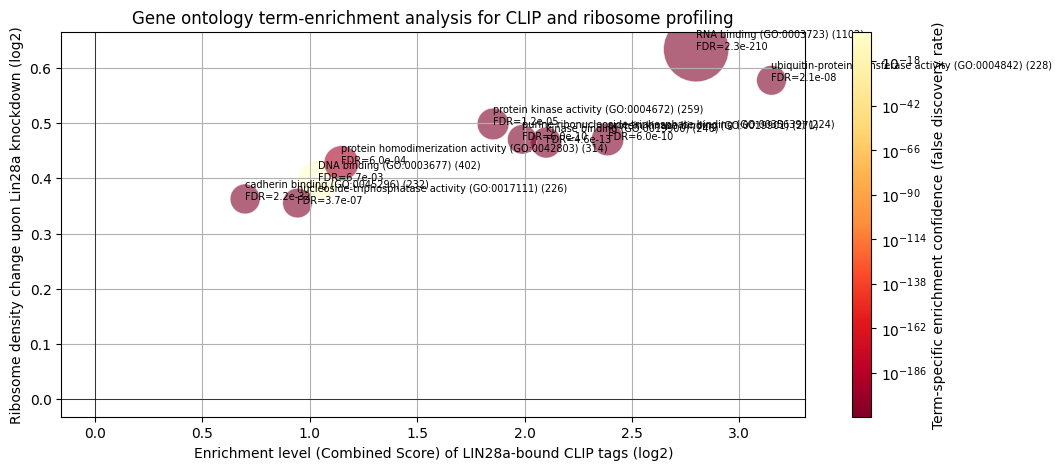

In [232]:
import matplotlib.colors as mcolors

larges = df_plot.nlargest(10, 'Gene_count')

norm = mcolors.Normalize(vmin=larges['FDR'].min(), vmax=larges['FDR'].max())

log_norm = mcolors.LogNorm(vmin=larges['FDR'].min(), vmax=larges['FDR'].max())
sm = plt.cm.ScalarMappable(cmap='YlOrRd_r', norm=log_norm)

# Create the scatter plot
plt.figure(figsize=(12, 5))
scatter = plt.scatter(larges['Enrichment_level'], larges['Ribosome_density_change'],
                      s=larges['Gene_count']*2, c=larges['FDR'],
                      cmap='YlOrRd_r', norm=norm, alpha=0.6, edgecolors="w", linewidth=0.5)

# Add color bar
cbar = plt.colorbar(sm)
cbar.set_label('Term-specific enrichment confidence (false discovery rate)')

# Add labels for each point
for i, row in larges.iterrows():
    plt.text(row['Enrichment_level'], row['Ribosome_density_change'],
             f"{row['GO_term']} ({row['Gene_count']})\nFDR={row['FDR']:.1e}",
             fontsize=7, ha='right' if row['Enrichment_level'] < 0 else 'left')

# Add axis labels and title
plt.xlabel('Enrichment level (Combined Score) of LIN28a-bound CLIP tags (log2)')
plt.ylabel('Ribosome density change upon Lin28a knockdown (log2)')
plt.title('Gene ontology term-enrichment analysis for CLIP and ribosome profiling')

# Add grid and axis lines
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Show plot
plt.savefig('result.svg')

In [233]:
larges

,GO_term,Enrichment_level,Ribosome_density_change,FDR,Gene_count
0,RNA binding (GO:0003723),2.799342,0.633909,2.256029e-210,1102
144,DNA binding (GO:0003677),1.038355,0.396611,6.738295e-03,402
99,protein homodimerization activity (GO:0042803),1.147296,0.427640,5.997938e-04,314
20,protein kinase binding (GO:0019901),2.386817,0.470278,5.982353e-10,271
54,protein kinase activity (GO:0004672),1.853614,0.498561,1.219586e-05,259
5,kinase binding (GO:0019900),2.100572,0.464769,4.581948e-13,246
1,cadherin binding (GO:0045296),0.698819,0.362757,2.209841e-32,232
29,ubiquitin-protein transferase activity (GO:000...,3.150089,0.577576,2.091797e-08,228
37,nucleoside-triphosphatase activity (GO:0017111),0.942515,0.355282,3.732175e-07,226
19,purine ribonucleoside triphosphate binding (GO...,1.989035,0.470613,5.982353e-10,224
